In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import numpy as np

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)


def global_contrast_normalization(x):
    
    mean = torch.mean(x)  # mean over all features (pixels) per sample
    x -= mean
    x_scale = torch.mean(torch.abs(x))
    x /= x_scale
    return x

In [4]:
def create_semisupervised_setting(labels, normal_classes, outlier_classes, known_outlier_classes,ratio_known_normal, ratio_known_outlier, ratio_pollution):
    
    idx_normal = np.argwhere(np.isin(labels, normal_classes)).flatten()
    idx_outlier = np.argwhere(np.isin(labels, outlier_classes)).flatten()
    idx_known_outlier_candidates = np.argwhere(np.isin(labels, known_outlier_classes)).flatten()

    n_normal = len(idx_normal)

    a = np.array([[1, 1, 0, 0],
                  [(1-ratio_known_normal), -ratio_known_normal, -ratio_known_normal, -ratio_known_normal],
                  [-ratio_known_outlier, -ratio_known_outlier, -ratio_known_outlier, (1-ratio_known_outlier)],
                  [0, -ratio_pollution, (1-ratio_pollution), 0]])
    b = np.array([n_normal, 0, 0, 0])
    x = np.linalg.solve(a, b)

    n_known_normal = int(x[0])
    n_unlabeled_normal = int(x[1])
    n_unlabeled_outlier = int(x[2])
    n_known_outlier = int(x[3])

    perm_normal = np.random.permutation(n_normal)
    perm_outlier = np.random.permutation(len(idx_outlier))
    perm_known_outlier = np.random.permutation(len(idx_known_outlier_candidates))

    idx_known_normal = idx_normal[perm_normal[:n_known_normal]].tolist()
    idx_unlabeled_normal = idx_normal[perm_normal[n_known_normal:n_known_normal+n_unlabeled_normal]].tolist()
    idx_unlabeled_outlier = idx_outlier[perm_outlier[:n_unlabeled_outlier]].tolist()
    idx_known_outlier = idx_known_outlier_candidates[perm_known_outlier[:n_known_outlier]].tolist()

    labels_known_normal = labels[idx_known_normal].tolist()
    labels_unlabeled_normal = labels[idx_unlabeled_normal].tolist()
    labels_unlabeled_outlier = labels[idx_unlabeled_outlier].tolist()
    labels_known_outlier = labels[idx_known_outlier].tolist()

    semi_labels_known_normal = np.ones(n_known_normal).astype(np.int32).tolist()
    semi_labels_unlabeled_normal = np.zeros(n_unlabeled_normal).astype(np.int32).tolist()
    semi_labels_unlabeled_outlier = np.zeros(n_unlabeled_outlier).astype(np.int32).tolist()
    semi_labels_known_outlier = (-np.ones(n_known_outlier).astype(np.int32)).tolist()

    list_idx = idx_known_normal + idx_unlabeled_normal + idx_unlabeled_outlier + idx_known_outlier
    list_labels = labels_known_normal + labels_unlabeled_normal + labels_unlabeled_outlier + labels_known_outlier
    list_semi_labels = (semi_labels_known_normal + semi_labels_unlabeled_normal + semi_labels_unlabeled_outlier
                        + semi_labels_known_outlier)

    return list_idx, list_labels, list_semi_labels

In [5]:
from torchvision.datasets import MNIST
class MyMNIST(MNIST):
  
    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

        self.semi_targets = torch.zeros_like(self.targets)

    def __getitem__(self, index):
      
        img, target, semi_target = self.data[index], int(self.targets[index]), int(self.semi_targets[index])

        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, semi_target, index

In [6]:
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset
from PIL import Image


def get_mnist(args, data_dir='/content/drive/MyDrive/Data'):
    
    n_classes = 2  # 0: normal, 1: outlier
    normal_classes = tuple([args.normal_class])
    outlier_classes = list(range(0, 10))
    outlier_classes.remove(args.normal_class)
    outlier_classes = tuple(outlier_classes)

    if args.n_known_outlier_classes == 0:
        known_outlier_classes = ()
    elif args.n_known_outlier_classes == 1:
        known_outlier_classes = tuple([args.known_outlier_class])
    else:
        known_outlier_classes = tuple(random.sample(outlier_classes, args.n_known_outlier_classes))
    
    transform = transforms.ToTensor()
    target_transform = transforms.Lambda(lambda x: int(x in outlier_classes))
    
    train = MyMNIST(root=data_dir, train=True,transform=transform, target_transform=target_transform,download=True)
    idx, _, semi_targets = create_semisupervised_setting(train.targets.cpu().data.numpy(), normal_classes,
                                                             outlier_classes, known_outlier_classes,
                                                             args.ratio_known_normal, args.ratio_known_outlier, args.ratio_pollution)
    train.semi_targets[idx] = torch.tensor(semi_targets)
    train = Subset(train, idx)          
    dataloader_train = DataLoader(train, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    
    test = MyMNIST(root=data_dir, train=False, transform=transform, target_transform=target_transform,
                                download=True)
    dataloader_test = DataLoader(test, batch_size=args.batch_size, 
                                  shuffle=True, num_workers=0)
    return dataloader_train, dataloader_test

In [7]:
!pip install barbar

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class network(nn.Module):
    def __init__(self, z_dim=32):
        super(network, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, z_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)


class autoencoder(nn.Module):
    def __init__(self, z_dim=32):
        super(autoencoder, self).__init__()
        self.z_dim = z_dim
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, 8, 5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(8, 4, 5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(4 * 7 * 7, z_dim, bias=False)

        self.deconv1 = nn.ConvTranspose2d(2, 4, 5, bias=False, padding=2)
        self.bn3 = nn.BatchNorm2d(4, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(4, 8, 5, bias=False, padding=3)
        self.bn4 = nn.BatchNorm2d(8, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 5, bias=False, padding=2)
        
    def encode(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        return self.fc1(x)
   
    def decode(self, x):
        x = x.view(x.size(0), int(self.z_dim / 16), 4, 4)
        x = F.interpolate(F.leaky_relu(x), scale_factor=2)
        x = self.deconv1(x)
        x = F.interpolate(F.leaky_relu(self.bn3(x)), scale_factor=2)
        x = self.deconv2(x)
        x = F.interpolate(F.leaky_relu(self.bn4(x)), scale_factor=2)
        x = self.deconv3(x)
        return torch.sigmoid(x)
        

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

In [9]:
from torch import optim
import torch.nn.functional as F

import numpy as np
from barbar import Bar



class TrainerDeepSAD:
    def __init__(self, args, data, device):
        self.args = args
        self.train_loader, self.test_loader = data
        self.device = device
    

    def pretrain(self):
        
        ae = autoencoder(self.args.latent_dim).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = optim.Adam(ae.parameters(), lr=self.args.lr_ae,
                               weight_decay=self.args.weight_decay_ae)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)
        
        ae.train()
        for epoch in range(self.args.num_epochs_ae):
            total_loss = 0
            for x, _, _, _ in Bar(self.train_loader):
                x = x.float().to(self.device)
                
                optimizer.zero_grad()
                x_hat = ae(x)
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim()))))
                reconst_loss.backward()
                optimizer.step()
                
                total_loss += reconst_loss.item()
            scheduler.step()
            print('Pretraining Autoencoder... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))
        self.save_weights_for_DeepSAD(ae, self.train_loader) 
    

    def save_weights_for_DeepSAD(self, model, dataloader):
        
        c = self.set_c(model, dataloader)
        net = network(self.args.latent_dim).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(),
                    'net_dict': net.state_dict()}, '/content/drive/MyDrive/weights/pretrained_parameters.pth')
    

    def set_c(self, model, dataloader, eps=0.1):
        
        model.eval()
        z_ = []
        with torch.no_grad():
            for x, _, _, _ in dataloader:
                x = x.float().to(self.device)
                z = model.encode(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c


    def train(self):
        
        net = network().to(self.device)
        eta=1
        eps=1e-6
        if self.args.pretrain==True:
            state_dict = torch.load('/content/drive/MyDrive/weights/pretrained_parameters.pth')
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.args.latent_dim).to(self.device)
        
        optimizer = optim.Adam(net.parameters(), lr=self.args.lr,
                               weight_decay=self.args.weight_decay)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                    milestones=self.args.lr_milestones, gamma=0.1)

        net.train()
        for epoch in range(self.args.num_epochs):
            total_loss = 0
            for x, _, sy, _ in Bar(self.train_loader):
                x = x.float().to(self.device)
                sy=sy.float().to(self.device)
                optimizer.zero_grad()
                z = net(x)
                dist = torch.sum((z-c) ** 2, dim=1)
                losses = torch.where(sy == 0, dist, eta * ((dist + eps) ** sy.float()))
                loss = torch.mean(losses)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
            scheduler.step()
            print('Training Deep SAD... Epoch: {}, Loss: {:.3f}'.format(
                   epoch, total_loss/len(self.train_loader)))
        self.net = net
        self.c = c

In [10]:
from sklearn.metrics import roc_auc_score


def eval(net, c, dataloader, device):
  

    scores = []
    labels = []
    epoch_loss=0
    nb=0
    eta=1.0
    eps=1e-6
    net.eval()
    print('Testing...')
    with torch.no_grad():
        for x, y, sy,_ in dataloader:
            x = x.float().to(device)
            y = y.float().to(device)
            sy= sy.float().to(device)
            z = net(x)
            dist = torch.sum((z-c) ** 2, dim=1)
            losses = torch.where(sy == 0, dist, eta * ((dist + eps) ** sy.float()))
            loss = torch.mean(losses)
            score=dist
            scores.append(score.detach().cpu())
            labels.append(y.cpu())
            epoch_loss+=loss
            nb+=1
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()
    print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))
    print('mean loss: {:.2f}'.format(epoch_loss/nb))
    return labels, scores

In [16]:
class Args:
  def __init__(self, nclass):
    self.num_epochs=10
    self.num_epochs_ae=10
    self.patience=50
    self.lr=1e-4
    self.weight_decay=0.5e-6
    self.weight_decay_ae=0.5e-3
    self.lr_ae=1e-4
    self.lr_milestones=[50]
    self.batch_size=200
    self.pretrain=True
    self.latent_dim=32
    self.normal_class=nclass
    self.ratio_known_outlier=0.01
    self.ratio_known_normal=0.0
    self.ratio_pollution=0.1
    self.known_outlier_class=(nclass+1)%10
    self.n_known_outlier_classes=1

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
nscores=[]
inscores=[]
outscores=[] 
for i in range(10):
  args = Args(i)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  data = get_mnist(args)
  deep_SAD = TrainerDeepSAD(args, data, device)
  if args.pretrain:
      deep_SAD.pretrain()
  deep_SAD.train()
  print("test for calss  ",i,".....")
  labels, scores = eval(deep_SAD.net, deep_SAD.c, data[1], device)
  nscores.append(roc_auc_score(labels, scores)*100)
  inscores.append(scores[np.where(labels==0)[0]])
  outscores.append(scores[np.where(labels==1)[0]])


6647/6647: [===============================>] - ETA 0.2s
Pretraining Autoencoder... Epoch: 0, Loss: 169.206
6647/6647: [===============================>] - ETA 0.1s
Training Deep SAD... Epoch: 0, Loss: 1.048
test for calss   0 .....
Testing...
ROC AUC score: 93.42
mean loss: 0.34
7566/7566: [===============================>] - ETA 0.2s
Pretraining Autoencoder... Epoch: 0, Loss: 180.260
7566/7566: [===============================>] - ETA 0.1s
Training Deep SAD... Epoch: 0, Loss: 0.793
test for calss   1 .....
Testing...
ROC AUC score: 96.03
mean loss: 0.46
6686/6686: [===============================>] - ETA 0.2s
Pretraining Autoencoder... Epoch: 0, Loss: 161.120
6686/6686: [===============================>] - ETA 0.1s
Training Deep SAD... Epoch: 0, Loss: 0.950
test for calss   2 .....
Testing...
ROC AUC score: 71.58
mean loss: 0.25
6880/6880: [===============================>] - ETA 0.2s
Pretraining Autoencoder... Epoch: 0, Loss: 164.575
6880/6880: [===============================>] - E

In [17]:
for i in range(10):
  print("ROC scores for class ",i," is: ",nscores[i])

ROC scores for class  0  is:  93.42388795873116
ROC scores for class  1  is:  96.02731625384189
ROC scores for class  2  is:  71.58255731835501
ROC scores for class  3  is:  79.99635458540293
ROC scores for class  4  is:  88.62394017125288
ROC scores for class  5  is:  62.675478956064836
ROC scores for class  6  is:  80.7820405724342
ROC scores for class  7  is:  89.60642361623104
ROC scores for class  8  is:  79.50445234415201
ROC scores for class  9  is:  84.88616355591358


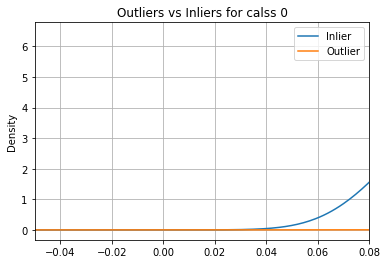

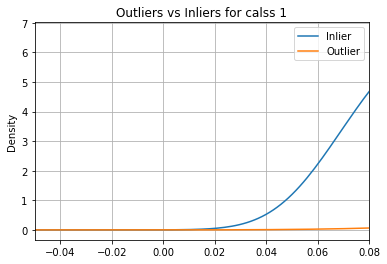

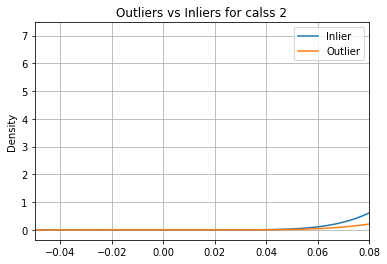

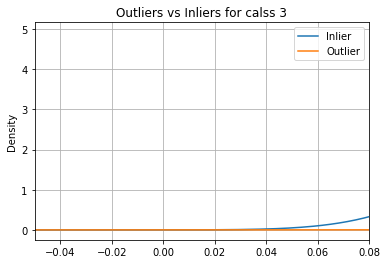

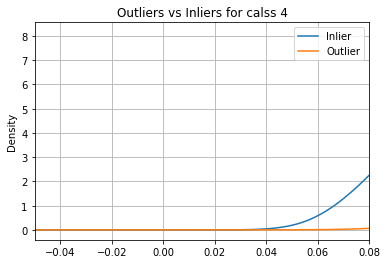

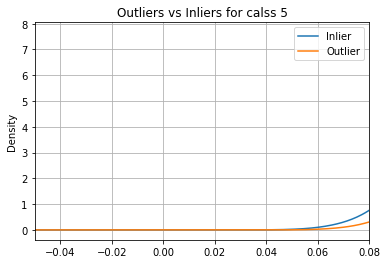

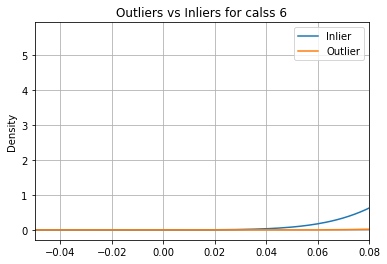

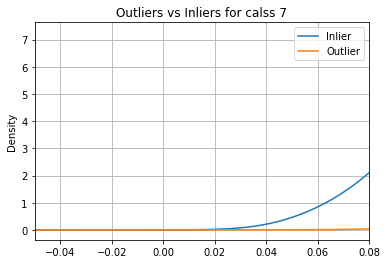

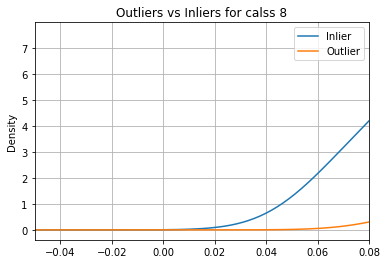

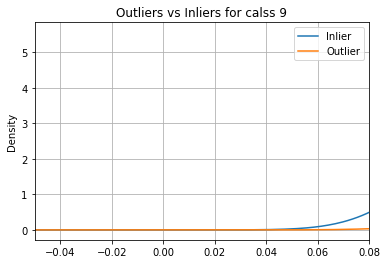

In [18]:
for i in range(10):
  in_ = pd.DataFrame(inscores[i], columns=['Inlier'])
  out_ = pd.DataFrame(outscores[i], columns=['Outlier'])
  fig, ax = plt.subplots()
  in_.plot.kde(ax=ax, legend=True, title='Outliers vs Inliers for calss '+str(i))
  out_.plot.kde(ax=ax, legend=True)
  plt.xlim(-0.05, 0.08)
  ax.grid(axis='x')
  ax.grid(axis='y')
  plt.show()